# References
   1. Dataset
       <a href="https://wiki.cancerimagingarchive.net/display/Public/CBIS-DDSM#225166291b3530e3e3034786a37019aba53cafba">The Cancer Imaging Archive (TCIA) Public Access</a>
        
   2. Pydicom
       <a href="https://pydicom.github.io/pydicom/stable/">Pydicom</a>
 
        


##### Importing all the neccesary libraries

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torchvision.io import read_image

import os
import re
import time
import glob
import shutil

#import pydicom
from PIL import Image


from models.model_cnn import *

#### Defining class needed for using custom dataset

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        #ptransform = transforms.ToTensor()
        #image = ptransform(Image.open(img_path))
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

#### Creating train and test data loaders

Feature batch shape: torch.Size([64, 1, 256, 256])
Labels batch shape: torch.Size([64])


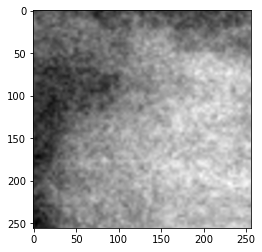

Label: 2 (BENIGN_WTIHOUT_CALLBACK)


In [3]:
train_dataset_directory = './dataset/train/'
train_csv = './dataset/train.csv'

test_dataset_directory = './dataset/test/'
test_csv = './dataset/test.csv'

label_dict = {
  0 : "MALIGNANT",
  1 : "BENIGN",
  2 : "BENIGN_WTIHOUT_CALLBACK"
}

training_data = CustomImageDataset(
    annotations_file = train_csv,
    img_dir = train_dataset_directory,
    transform = transforms.Compose([
        transforms.RandomCrop(256, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]))

testing_data = CustomImageDataset(
    annotations_file = test_csv,
    img_dir = test_dataset_directory,
    transform = transforms.Compose([
        transforms.RandomCrop(256, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]))

batch_size = 64

train_dataloader = DataLoader(training_data, batch_size= batch_size, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size= batch_size, shuffle=True)


# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label} ({label_dict[label.item()]})")

#### Defining the model

In [4]:
model_inuse = 'cnn_test'

model = CNN_test(model_inuse)

print(model)

CNN(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (14): Con

In [5]:
use_gpu = torch.cuda.is_available()

In [6]:
print_freq = 16 # every 100 batches, accuracy printed. Here, each batch includes "batch_size" data points
# CIFAR10 has 50,000 training data, and 10,000 validation data.

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
        

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def adjust_learning_rate(optimizer, epoch):
    """For resnet, the lr starts from 0.1, and is divided by 10 at 80 and 120 epochs"""
    adjust_list = [80, 120]
    if epoch in adjust_list: 
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.1
            
            
def train(trainloader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    model.train()

    end = time.time()
    for i, (input, target) in enumerate(trainloader):
        # measure data loading time
        data_time.update(time.time() - end)
        
        input = input.float()
        input, target = input.cuda(), target.cuda()

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss
        prec = accuracy(output, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec.item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()


        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec {top1.val:.3f}% ({top1.avg:.3f}%)'.format(
                   epoch, i, len(trainloader), batch_time=batch_time,
                   data_time=data_time, loss=losses, top1=top1))

            

def validate(val_loader, model, criterion ):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            
            input = input.float()
            input, target = input.cuda(), target.cuda()

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
            prec = accuracy(output, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:  # This line shows how frequently print out the status. e.g., i%5 => every 5 batch, prints out
                print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec {top1.val:.3f}% ({top1.avg:.3f}%)'.format(
                   i, len(val_loader), batch_time=batch_time, loss=losses,
                   top1=top1))

    print(' * Prec {top1.avg:.3f}% '.format(top1=top1))
    return top1.avg


In [7]:
lr = 0.1
weight_decay = 1e-4
epochs = 150
best_prec = 0

#model = nn.DataParallel(model).cuda()
model.cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
#cudnn.benchmark = True

if not os.path.exists('result'):
    os.makedirs('result')
fdir = 'result/'+str(model_inuse)
if not os.path.exists(fdir):
    os.makedirs(fdir)
        

for epoch in range(0, epochs):
    adjust_learning_rate(optimizer, epoch)

    train(train_dataloader, model, criterion, optimizer, epoch)
    
    # evaluate on test set
    print("Validation starts")
    prec = validate(test_dataloader, model, criterion)

    # remember best precision and save checkpoint
#     is_best = prec > best_prec
#     best_prec = max(prec,best_prec)
#     print('best acc: {:1f}'.format(best_prec))
#     save_checkpoint({
#         'epoch': epoch + 1,
#         'state_dict': model.state_dict(),
#         'best_prec': best_prec,
#         'optimizer': optimizer.state_dict(),
#     }, is_best, fdir)
    

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: [0][0/21]	Time 1.135 (1.135)	Data 0.276 (0.276)	Loss 0.9687 (0.9687)	Prec 46.875% (46.875%)
Epoch: [0][16/21]	Time 0.536 (0.579)	Data 0.289 (0.292)	Loss 1.0303 (7.7436)	Prec 51.562% (45.221%)
Validation starts
Test: [0/6]	Time 0.472 (0.472)	Loss 1351.4244 (1351.4244)	Prec 46.875% (46.875%)
 * Prec 38.727% 
Epoch: [1][0/21]	Time 0.419 (0.419)	Data 0.259 (0.259)	Loss 2.3931 (2.3931)	Prec 53.125% (53.125%)
Epoch: [1][16/21]	Time 0.543 (0.534)	Data 0.265 (0.261)	Loss 1.3407 (2.4153)	Prec 43.750% (47.059%)
Validation starts
Test: [0/6]	Time 0.419 (0.419)	Loss 1.8088 (1.8088)	Prec 40.625% (40.625%)
 * Prec 38.727% 
Epoch: [2][0/21]	Time 0.429 (0.429)	Data 0.267 (0.267)	Loss 1.2753 (1.2753)	Prec 39.062% (39.062%)
Epoch: [2][16/21]	Time 0.540 (0.534)	Data 0.266 (0.262)	Loss 1.1455 (1.2782)	Prec 43.750% (44.761%)
Validation starts
Test: [0/6]	Time 0.403 (0.403)	Loss 1.1752 (1.1752)	Prec 28.125% (28.125%)
 * Prec 38.727% 
Epoch: [3][0/21]	Time 0.425 (0.425)	Data 0.263 (0.263)	Loss 1.0355 

Validation starts
Test: [0/6]	Time 0.402 (0.402)	Loss 0.8683 (0.8683)	Prec 50.000% (50.000%)
 * Prec 41.910% 
Epoch: [27][0/21]	Time 0.415 (0.415)	Data 0.252 (0.252)	Loss 0.9835 (0.9835)	Prec 50.000% (50.000%)
Epoch: [27][16/21]	Time 0.543 (0.535)	Data 0.249 (0.258)	Loss 0.8957 (0.9172)	Prec 56.250% (47.794%)
Validation starts
Test: [0/6]	Time 0.391 (0.391)	Loss 1.0286 (1.0286)	Prec 29.688% (29.688%)
 * Prec 40.053% 
Epoch: [28][0/21]	Time 0.413 (0.413)	Data 0.250 (0.250)	Loss 0.9359 (0.9359)	Prec 46.875% (46.875%)
Epoch: [28][16/21]	Time 0.547 (0.543)	Data 0.276 (0.267)	Loss 1.0180 (0.9148)	Prec 42.188% (49.724%)
Validation starts
Test: [0/6]	Time 0.413 (0.413)	Loss 0.8835 (0.8835)	Prec 48.438% (48.438%)
 * Prec 42.175% 
Epoch: [29][0/21]	Time 0.412 (0.412)	Data 0.253 (0.253)	Loss 0.8335 (0.8335)	Prec 50.000% (50.000%)
Epoch: [29][16/21]	Time 0.541 (0.534)	Data 0.254 (0.261)	Loss 0.9184 (0.9149)	Prec 40.625% (45.312%)
Validation starts
Test: [0/6]	Time 0.405 (0.405)	Loss 0.9874 (0.987

Epoch: [53][0/21]	Time 0.419 (0.419)	Data 0.257 (0.257)	Loss 0.9433 (0.9433)	Prec 43.750% (43.750%)
Epoch: [53][16/21]	Time 0.544 (0.536)	Data 0.259 (0.262)	Loss 0.9243 (0.9146)	Prec 51.562% (49.724%)
Validation starts
Test: [0/6]	Time 0.406 (0.406)	Loss 1.0750 (1.0750)	Prec 35.938% (35.938%)
 * Prec 41.379% 
Epoch: [54][0/21]	Time 0.438 (0.438)	Data 0.273 (0.273)	Loss 0.9126 (0.9126)	Prec 54.688% (54.688%)
Epoch: [54][16/21]	Time 0.537 (0.540)	Data 0.268 (0.273)	Loss 0.9155 (0.9199)	Prec 45.312% (49.724%)
Validation starts
Test: [0/6]	Time 0.410 (0.410)	Loss 0.8499 (0.8499)	Prec 59.375% (59.375%)
 * Prec 51.459% 
Epoch: [55][0/21]	Time 0.474 (0.474)	Data 0.284 (0.284)	Loss 0.9618 (0.9618)	Prec 46.875% (46.875%)
Epoch: [55][16/21]	Time 0.544 (0.541)	Data 0.258 (0.271)	Loss 0.9928 (0.9025)	Prec 51.562% (49.173%)
Validation starts
Test: [0/6]	Time 0.424 (0.424)	Loss 0.9680 (0.9680)	Prec 39.062% (39.062%)
 * Prec 40.849% 
Epoch: [56][0/21]	Time 0.435 (0.435)	Data 0.271 (0.271)	Loss 0.8886

Validation starts
Test: [0/6]	Time 0.398 (0.398)	Loss 0.9358 (0.9358)	Prec 54.688% (54.688%)
 * Prec 40.849% 
Epoch: [80][0/21]	Time 0.415 (0.415)	Data 0.255 (0.255)	Loss 0.9685 (0.9685)	Prec 46.875% (46.875%)
Epoch: [80][16/21]	Time 0.542 (0.534)	Data 0.271 (0.257)	Loss 0.9005 (0.9116)	Prec 53.125% (50.092%)
Validation starts
Test: [0/6]	Time 0.405 (0.405)	Loss 1.0072 (1.0072)	Prec 40.625% (40.625%)
 * Prec 41.910% 
Epoch: [81][0/21]	Time 0.411 (0.411)	Data 0.252 (0.252)	Loss 0.8203 (0.8203)	Prec 51.562% (51.562%)
Epoch: [81][16/21]	Time 0.538 (0.531)	Data 0.255 (0.255)	Loss 0.9330 (0.9071)	Prec 46.875% (48.897%)
Validation starts
Test: [0/6]	Time 0.403 (0.403)	Loss 1.0766 (1.0766)	Prec 43.750% (43.750%)
 * Prec 42.175% 
Epoch: [82][0/21]	Time 0.425 (0.425)	Data 0.266 (0.266)	Loss 0.8965 (0.8965)	Prec 35.938% (35.938%)
Epoch: [82][16/21]	Time 0.538 (0.535)	Data 0.261 (0.262)	Loss 1.0485 (0.9100)	Prec 42.188% (47.794%)
Validation starts
Test: [0/6]	Time 0.404 (0.404)	Loss 1.0206 (1.020

Epoch: [106][0/21]	Time 0.424 (0.424)	Data 0.263 (0.263)	Loss 0.9738 (0.9738)	Prec 48.438% (48.438%)
Epoch: [106][16/21]	Time 0.546 (0.544)	Data 0.266 (0.285)	Loss 0.8416 (0.9106)	Prec 60.938% (51.471%)
Validation starts
Test: [0/6]	Time 0.407 (0.407)	Loss 0.9698 (0.9698)	Prec 46.875% (46.875%)
 * Prec 41.114% 
Epoch: [107][0/21]	Time 0.439 (0.439)	Data 0.274 (0.274)	Loss 0.9934 (0.9934)	Prec 40.625% (40.625%)
Epoch: [107][16/21]	Time 0.540 (0.544)	Data 0.281 (0.271)	Loss 0.9517 (0.9203)	Prec 48.438% (49.540%)
Validation starts
Test: [0/6]	Time 0.405 (0.405)	Loss 1.0651 (1.0651)	Prec 40.625% (40.625%)
 * Prec 42.440% 
Epoch: [108][0/21]	Time 0.432 (0.432)	Data 0.265 (0.265)	Loss 0.8306 (0.8306)	Prec 46.875% (46.875%)
Epoch: [108][16/21]	Time 0.540 (0.542)	Data 0.274 (0.269)	Loss 0.9327 (0.9142)	Prec 45.312% (49.449%)
Validation starts
Test: [0/6]	Time 0.418 (0.418)	Loss 1.0643 (1.0643)	Prec 40.625% (40.625%)
 * Prec 41.910% 
Epoch: [109][0/21]	Time 0.416 (0.416)	Data 0.256 (0.256)	Loss

Epoch: [132][16/21]	Time 0.579 (0.537)	Data 0.278 (0.265)	Loss 0.9925 (0.9130)	Prec 51.562% (50.092%)
Validation starts
Test: [0/6]	Time 0.418 (0.418)	Loss 0.9374 (0.9374)	Prec 43.750% (43.750%)
 * Prec 40.584% 
Epoch: [133][0/21]	Time 0.419 (0.419)	Data 0.259 (0.259)	Loss 0.8890 (0.8890)	Prec 45.312% (45.312%)
Epoch: [133][16/21]	Time 0.547 (0.538)	Data 0.259 (0.261)	Loss 0.8151 (0.9102)	Prec 56.250% (49.908%)
Validation starts
Test: [0/6]	Time 0.424 (0.424)	Loss 0.9813 (0.9813)	Prec 45.312% (45.312%)
 * Prec 41.114% 
Epoch: [134][0/21]	Time 0.422 (0.422)	Data 0.260 (0.260)	Loss 0.9459 (0.9459)	Prec 50.000% (50.000%)
Epoch: [134][16/21]	Time 0.546 (0.537)	Data 0.254 (0.261)	Loss 0.8711 (0.9214)	Prec 51.562% (49.540%)
Validation starts
Test: [0/6]	Time 0.426 (0.426)	Loss 0.9718 (0.9718)	Prec 46.875% (46.875%)
 * Prec 41.645% 
Epoch: [135][0/21]	Time 0.423 (0.423)	Data 0.262 (0.262)	Loss 0.8184 (0.8184)	Prec 51.562% (51.562%)
Epoch: [135][16/21]	Time 0.541 (0.541)	Data 0.277 (0.265)	Los